# How PCA works

There are some excellent notes here from Victor Lavrenko: https://www.youtube.com/playlist?list=PLBv09BD7ez_5_yapAg86Od6JeeypkS4YM.

Assume we have data X in the format where each column represents a piece of data. So for an image dataset each column would represent an image, squashed into a single vector. The dimensions of this dataset are d x n, where d is the number of dimensions in the dataset (e.g. # of pixels in an image), and n is the number of datapoints.

The steps are as follows:
- Normalise the data by subtracting the mean and scaling such that the variance of the data to one. These calculations are performed per row on the attributes of the dataset that give the values of the data per dimension. So mu and sigma are vectors of dimension d, and the data is transformed via X' = (X - mu) / sigma
- Compute the covariance matrix, Sigma. Given that the data has been normalised, so that each attribute has mean zero, this calculation just averages the product of attributes, for each attribute pair, across the data set. The covariance matrix is symmetrical so that only half the matrix needs to be calculated, and the remainder can be copied
- Calculate the Eigenvectors and Eigenvalues of the covariance matrix. The EIgenvectors define an n-dimensional space in which the dimensions (the Eigenvectors) are orthogonal. We can translate each datapoint in X' to Y' by computing the dot product of X' with each Eigenvector in turn. The Eigenvectors can be interpreted as the directions in which the data shows the maximum variance
- Decide on the number of Eigenvectors to use in the reduced representation of the data, m. This can be set by considering a minimum level of variance to maintain; since the Eigenvalues give the variance for each dimension, we can calculate the cumulative variance as a % value and compare this to the threshold
- Once we have m, we can re-construct the data as the sumproduct of the new data coordinates and the Eigenvectors



# Implementing PCA

Do this in two steps as below. The first function applies the PCA decomposition to get the Eigenvalues and Eigenvectors. Given this, the second function can return a reduced representation of the original data, using m << d dimensions. If we excuse the use of libraries for linear algebra and matrix multiplication, it isn't much code.

In [43]:
import numpy as np


def get_pca(X):
    """
    inputs:     X
    outputs:    mu, sigma, X_norm, evalues, evectors
    X         - data in numpy 2d array format, dims of d x n
    mu, sigma - mean, stdev of data used to normalise it
    X_norm    - normalised data such that each attribute has mean 0 and variance 1
    evalues   - Eigen values of covar
    evectors  - Eigen vectors of covar
    """
    # Normalise the data by subtracting the mean and setting the variance of the data to one
    # These calculations are performed per row on the attributes of the dataset that give the values of the data per dimension
    # So mu and sigma are vectors of dimension d, and the data is transformed via X' = (X - mu) / sigma
    d = X.shape[0]
    mu = np.mean(X, axis=1)
    sigma = np.std(X, axis=1)
    X_norm = (X - np.expand_dims(mu, axis=1)) / np.expand_dims(sigma, axis=1)

    # Compute the covariance matrix, Sigma.
    # Given that the data has been normalised, so that each attribute has mean zero,
    # ...this calculation just averages the product of attributes,
    # ...for each attribute pair, across the data set
    # The covariance matrix is symmetrical so that only half the matrix needs to be calculated,
    # ...and the remainder can be copied
    covar = np.zeros((d, d))
    for i in range(d):
        for j in range(i, d):
            covar[i, j] = np.mean(X_norm[i, :] * X_norm[j, :])
            covar[j, i] = covar[i, j]

    # Calculate the Eigenvectors and Eigenvalues of the covariance matrix
    evalues, evectors = np.linalg.eig(covar)

    return (mu, sigma, X_norm, evalues, evectors)


def get_reduced_pca_representation(mu, sigma, X_norm, evalues, evectors, m):
    """
    inputs: mu, sigma, X_norm, evalues, evectors, m
    output: X_red
    m       number of (reduced) dimensions on which to reconstruct the data using the Eigenvectors
    X_red   the original data reconstructed from the m leading Eigenvectors
    """
    # compute Y_norm as the coordinates of the normalised data in the Eigenvector space (the first m)
    # this is a dot product of each point on each Eigenvector
    Y_norm_red = np.transpose(np.transpose(X_norm) @ evectors[:, :m])

    # compute the reduced normalised projection into the original space
    X_norm_red = evectors[:, :m] @ Y_norm_red

    # undo the normalisation
    X_red = X_norm_red * \
        np.expand_dims(sigma, axis=1) + np.expand_dims(mu, axis=1)

    return X_red


# Eigen faces

Try the Olivett faces dataset available within scikit learn: https://scikit-learn.org/0.19/datasets/olivetti_faces.html

First use the PCA function defined above to extract the Eigenvalues and Eigenvectors. This takes a few minutes.

In [44]:
from sklearn import datasets
X = np.transpose(datasets.fetch_olivetti_faces().data)
print(f'Dimensions of dataset: {X.shape}')
print(f'Number of images     : {X.shape[1]}')
mu, sigma, X_norm, evalues, evectors = get_pca(X)

Dimensions of dataset: (4096, 400)
Number of images     : 400


## What does the mu-face and Eigenvectors look like?

Before we apply PCA to reduce the dimensionality of the dataset, it's useful to visualise the mean of the dataset. We can use imshow from matplotlib to do this. Note that since the mu vector is 1-d, we need to shape it into 64 x 64 dimensions first. 

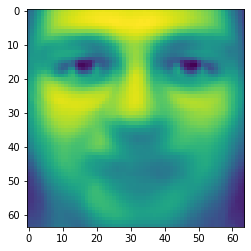

In [45]:
from matplotlib.pyplot import imshow

imshow(mu.reshape((64, 64)))

Similarly we can view the first 5 Eigenvectors.

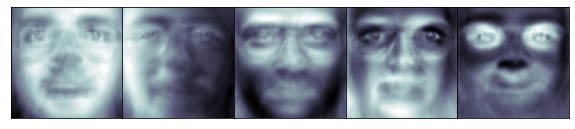

In [46]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots(1, 5, figsize=(10, 10))
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(5):
    ax[i].xaxis.set_major_locator(plt.NullLocator())
    ax[i].yaxis.set_major_locator(plt.NullLocator())
    ax[i].imshow(evectors[:, i].reshape(64, 64), cmap="bone")

## How many dimensions do we need?

The original data has dimensions 64 * 64 = 4096. How much can we reduce this if we use the Eigenvector space? It turns out, quite a bit! In the images below each row represents a given data point. The left most one is the original, then we have the reduced representation using, 5, 10, 20, 50 and 100 dimensions.

Very interesting to see how the images progress as you add more Eigenvectors in. At 100 there is certainly decent recognition, which is lot less than 4096! It seems to depend on the face. For some, where there is perhaps a less frequent feature, such as a moustache, it takes a little more to get to the recognition stage.

In [47]:
X_red_5 = get_reduced_pca_representation(mu, sigma, X_norm, evalues, evectors, m=5)
X_red_10 = get_reduced_pca_representation(mu, sigma, X_norm, evalues, evectors, m=10)
X_red_20 = get_reduced_pca_representation(mu, sigma, X_norm, evalues, evectors, m=20)
X_red_50 = get_reduced_pca_representation(mu, sigma, X_norm, evalues, evectors, m=50)
X_red_100 = get_reduced_pca_representation(mu, sigma, X_norm, evalues, evectors, m=100)
X_orig_plus_reds = [X, X_red_5, X_red_10, X_red_20, X_red_50, X_red_100]

Text(0.02, 0.5, 'Images: [ 81 370 395  59 367]')

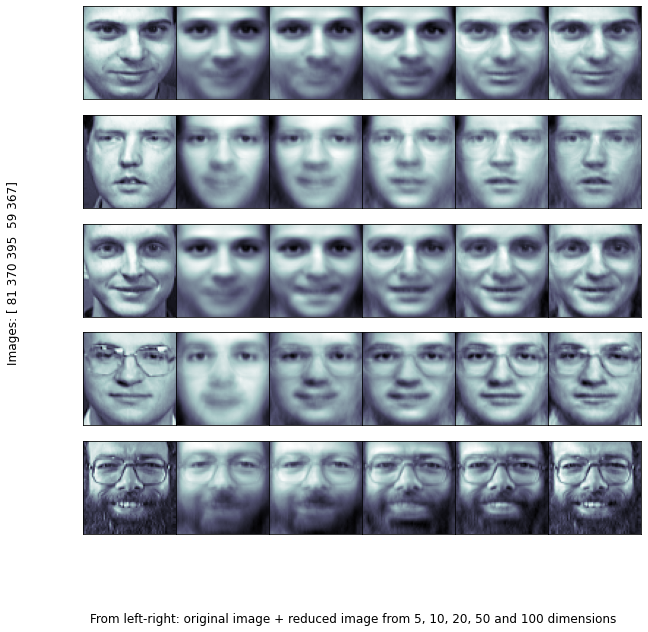

In [48]:
fig, ax = plt.subplots(5, 6, figsize=(10, 10))
fig.subplots_adjust(hspace=0, wspace=0)

# take 5 random ones from the 400
images_to_view = np.random.choice(400, 5)

for i in range(5):
    for j in range(6):
        ax[i, j].xaxis.set_major_locator(plt.NullLocator())
        ax[i, j].yaxis.set_major_locator(plt.NullLocator())
        ax[i, j].imshow(X_orig_plus_reds[j][:,images_to_view[i]].reshape(64, 64), cmap="bone")

fig.supxlabel(f'From left-right: original image + reduced image from 5, 10, 20, 50 and 100 dimensions')
fig.supylabel(f'Images: {images_to_view}')

## Rotate some faces; what happens to the Eigenvectors?

In the Olivetti dataset the faces are oriented, for the most part, in the same direction i.e. from the top, eyes, nose and mouth. What if we randomly rotated the images by 0, 90, 180, 270 degrees? Let's see.....

In [49]:
X_rand_rot = X
for i in range(X_rand_rot.shape[1]):
    img_arr = X_rand_rot[:,i].reshape((64,64))
    num_rot = np.random.choice(4)
    for k in range(num_rot):
        img_arr = np.rot90(img_arr)
    X_rand_rot[:,i] = img_arr.reshape(4096)

Let's view a few.

Text(0.5, 0.01, 'Random rotation by 0, 90, 180, 270 degrees')

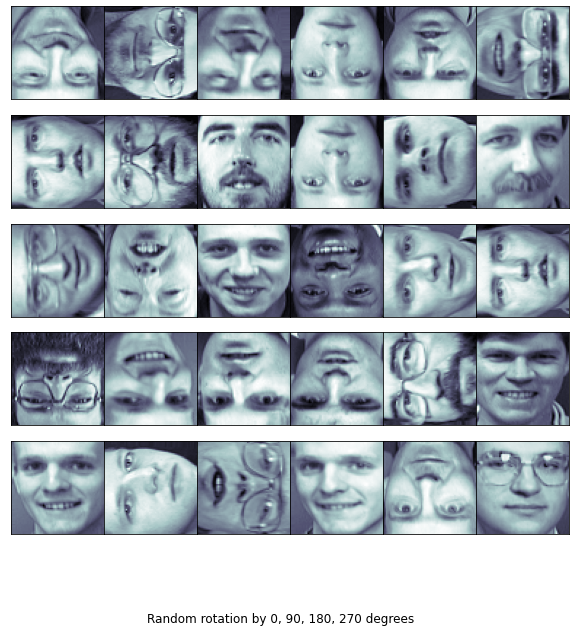

In [50]:
fig, ax = plt.subplots(5, 6, figsize=(10, 10))
fig.subplots_adjust(hspace=0, wspace=0)

# take 5 random ones from the 400
images_to_view = np.random.choice(400, (5,6))

for i in range(5):
    for j in range(6):
        ax[i, j].xaxis.set_major_locator(plt.NullLocator())
        ax[i, j].yaxis.set_major_locator(plt.NullLocator())
        ax[i, j].imshow(X_rand_rot[:,images_to_view[i,j]].reshape(64, 64), cmap="bone")

fig.supxlabel(f'Random rotation by 0, 90, 180, 270 degrees')

The image grid below is set out as above for the non-rotated images, showing how the reduced image compares to the original for a given number of reduced dimensions. It actually does quite well. Not quite as good I think as the original set, but with 100 dimensions there is a definite resemblance.

In [51]:
mu_rand_rot, sigma_rand_rot, X_norm_rand_rot, evalues_rand_rot, evectors_rand_rot = get_pca(X_rand_rot)

In [52]:
X_red_5 = get_reduced_pca_representation(mu_rand_rot, sigma_rand_rot, X_norm_rand_rot, evalues_rand_rot, evectors_rand_rot, m=5)
X_red_10 = get_reduced_pca_representation(mu_rand_rot, sigma_rand_rot, X_norm_rand_rot, evalues_rand_rot, evectors_rand_rot, m=10)
X_red_20 = get_reduced_pca_representation(mu_rand_rot, sigma_rand_rot, X_norm_rand_rot, evalues_rand_rot, evectors_rand_rot, m=20)
X_red_50 = get_reduced_pca_representation(mu_rand_rot, sigma_rand_rot, X_norm_rand_rot, evalues_rand_rot, evectors_rand_rot, m=50)
X_red_100 = get_reduced_pca_representation(mu_rand_rot, sigma_rand_rot, X_norm_rand_rot, evalues_rand_rot, evectors_rand_rot, m=100)
X_orig_plus_reds = [X_rand_rot, X_red_5, X_red_10, X_red_20, X_red_50, X_red_100]

Text(0.02, 0.5, 'Images: [308 142 211 168 263]')

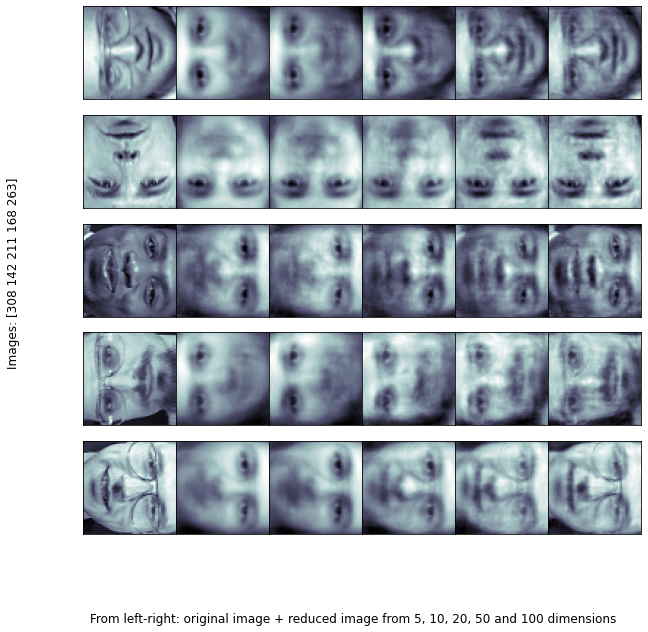

In [53]:
fig, ax = plt.subplots(5, 6, figsize=(10, 10))
fig.subplots_adjust(hspace=0, wspace=0)

# take 5 random ones from the 400
images_to_view = np.random.choice(400, 5)

for i in range(5):
    for j in range(6):
        ax[i, j].xaxis.set_major_locator(plt.NullLocator())
        ax[i, j].yaxis.set_major_locator(plt.NullLocator())
        ax[i, j].imshow(X_orig_plus_reds[j][:,images_to_view[i]].reshape(64, 64), cmap="bone")

fig.supxlabel(f'From left-right: original image + reduced image from 5, 10, 20, 50 and 100 dimensions')
fig.supylabel(f'Images: {images_to_view}')

We can also view the Eigenvectors / Rorschach ink blots.

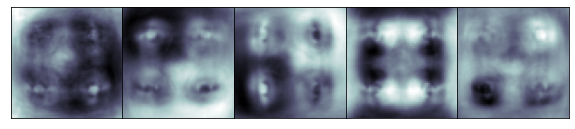

In [54]:
fig, ax = plt.subplots(1, 5, figsize=(10, 10))
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(5):
    ax[i].xaxis.set_major_locator(plt.NullLocator())
    ax[i].yaxis.set_major_locator(plt.NullLocator())
    ax[i].imshow(evectors_rand_rot[:, i].reshape(64, 64), cmap="bone")

# Eigen digits


In [55]:
X = np.transpose(datasets.load_digits().data)
print(f'Number of instances:  {X.shape[1]}')
print(f'Number of dimensions: {X.shape[0]}')

Number of instances:  1797
Number of dimensions: 64


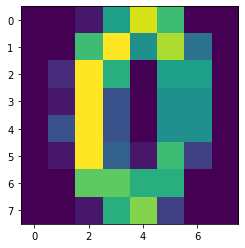

In [56]:
# Let's view some
imshow(X[:,10].reshape(8,8))

In [57]:
sigma + (sigma==0)*1

array([0.18046872, 0.18926673, 0.19449872, ..., 0.18760698, 0.18338676,
       0.1804086 ])

In [58]:
# Normalise the data by subtracting the mean and setting the variance of the data to one.
# These calculations are performed per row on the attributes of the dataset that give the values of the data per dimension.
# So mu and sigma are vectors of dimension d, and the data is transformed via X' = (X - mu) / sigma
d = X.shape[0]
mu = np.mean(X, axis=1)
sigma = np.std(X, axis=1)
X_norm = (X - np.expand_dims(mu, axis=1)) / np.expand_dims(sigma + (sigma==0)*1, axis=1)

# Compute the covariance matrix, Sigma. Given that the data has been normalised, so that each attribute has mean zero, this calculation just averages the product of attributes, for each attribute pair, across the data set. THe covariance matrix is symmetrical so that only half the matrix needs to be calculated, and the remainder can be copied
covar = np.zeros((d, d))
for i in range(d):
    for j in range(i, d):
        covar[i, j] = np.mean(X_norm[i, :] * X_norm[j, :])
        covar[j, i] = covar[i, j]

# Calculate the Eigenvectors and Eigenvalues of the covariance matrix. The EIgenvectors define an n-dimensional space in which the dimensions (the Eigenvectors) are orthogonal. We can translate each datapoint in X' to Y' by computing the dot product of X' with each Eigenvector in turn. Given these new co-ordinates, the Eigenvectors can be interpreted as the directions in which the data (as measured in the new dimension), shows the maximum variance
evalues, evectors = np.linalg.eig(covar)
#covar

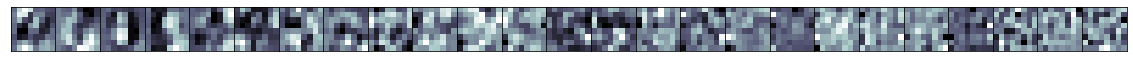

In [59]:
fig, ax = plt.subplots(1, 25, figsize=(20, 20))
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(25):
    ax[i].xaxis.set_major_locator(plt.NullLocator())
    ax[i].yaxis.set_major_locator(plt.NullLocator())
    ax[i].imshow(evectors[:, i].reshape(8,8), cmap="bone")

In [60]:
X_red_5 = get_reduced_pca_representation(mu, sigma, X_norm, evalues, evectors, m=5)
X_red_10 = get_reduced_pca_representation(mu, sigma, X_norm, evalues, evectors, m=10)
X_red_20 = get_reduced_pca_representation(mu, sigma, X_norm, evalues, evectors, m=20)
X_red_50 = get_reduced_pca_representation(mu, sigma, X_norm, evalues, evectors, m=50)
X_red_64 = get_reduced_pca_representation(mu, sigma, X_norm, evalues, evectors, m=64)
X_orig_plus_reds = [X, X_red_5, X_red_10, X_red_20, X_red_50, X_red_64]

Text(0.02, 0.5, 'Images: [ 939  370  355 1116  102  397 1332   34  715  761]')

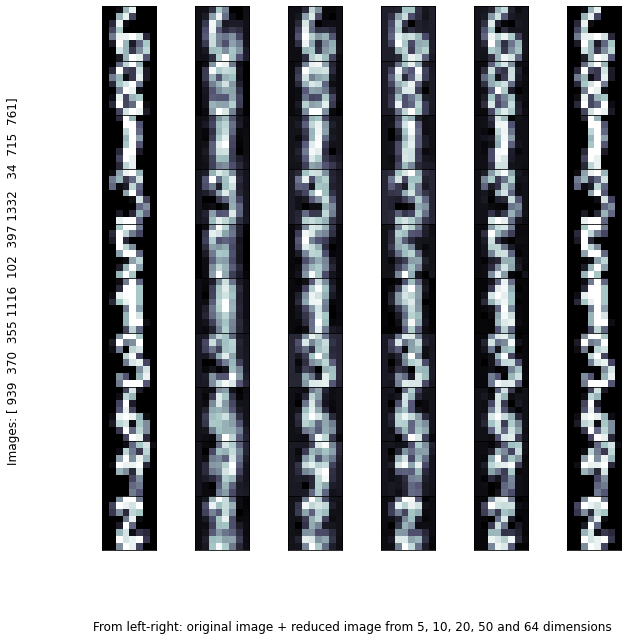

In [61]:
fig, ax = plt.subplots(10, 6, figsize=(10, 10))
fig.subplots_adjust(hspace=0, wspace=0)

# take 5 random ones from the 400
images_to_view = np.random.choice(1797, 10)

for i in range(10):
    for j in range(6):
        ax[i, j].xaxis.set_major_locator(plt.NullLocator())
        ax[i, j].yaxis.set_major_locator(plt.NullLocator())
        ax[i, j].imshow(X_orig_plus_reds[j][:,images_to_view[i]].reshape(8, 8), cmap="bone")

fig.supxlabel(f'From left-right: original image + reduced image from 5, 10, 20, 50 and 64 dimensions')
fig.supylabel(f'Images: {images_to_view}')

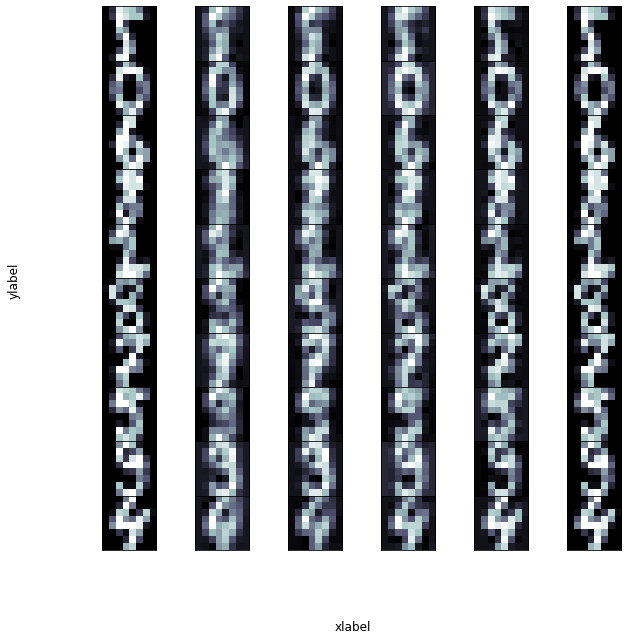

In [62]:
def display_images_in_grid(m, n, fig_size, img_dict, reshape_size, xlabel, ylabel):
    """
    display grid of images
    img_dict is dictionary mapping tuple of row-col pairs to 1-d images to be unrolled
    """
    fig, ax = plt.subplots(m, n, figsize=fig_size)
    fig.subplots_adjust(hspace=0, wspace=0)

    for i in range(m):
        for j in range(n):
            ax[i, j].xaxis.set_major_locator(plt.NullLocator())
            ax[i, j].yaxis.set_major_locator(plt.NullLocator())
            ax[i, j].imshow(img_dict[(i,j)].reshape(reshape_size), cmap="bone")

    fig.supxlabel(xlabel)
    fig.supylabel(ylabel)
    
images_to_view = np.random.choice(1797, 10)
img_dict = {(i,j):X_orig_plus_reds[j][:,images_to_view[i]] for i in range(10) for j in range(6)}
display_images_in_grid(10, 6, (10,10), img_dict, (8,8), 'xlabel', 'ylabel')



# Eigen curve (changes)

To add




In [63]:
import pandas as pd

x = pd.read_csv('GLC Nominal daily data_1979 to 2022.csv')
